In [11]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
# import sklearn
# print("sklearn version: ", sklearn.__version__)
# assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

TF version:  2.4.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [1]:
import numpy as np
import pandas as pd
import os
import time
# import scoring as scoring
import pickle
import gzip
from pyarrow import csv
import csv
# train_path = "D:/2022AIComp_data/train.csv"
# test_path = "D:/2022AIComp_data/test.csv"

#---------------------- Load Train,Test DF
train_pd = pd.read_csv("D:/2022AIComp_data/train.csv")
test_pd = pd.read_csv("D:/2022AIComp_data/test.csv")

print("Train: %s, Test: %s" %(train_pd.shape, test_pd.shape))
train_pd.head()
print(train_pd.iloc[:,0].unique())
# test_pd.head()

Train: (33600, 514), Test: (7820, 514)
['out' 'in' 'normal' 'other' 'noise']


In [72]:
def data_shape(data_li):
    for data in data_li:
        vnames = [name for name in globals() if globals()[name] is data]
        print(vnames[0],'.shape : ',data.shape)

def data_reshape(data, shape):
    X_train=data[0].reshape(shape)
    X_test=data[1].reshape(shape)
    submit_test=data[2].reshape(shape)
    return X_train, X_test, submit_test
        
# X_train = np.array(train_pd.iloc[:,1:])
X_train = np.array(train_pd.iloc[:3600,1:])

y_train = train_pd.iloc[:3600,0].replace(['out','in', 'normal', 'other', 'noise'],[0,1,2,3,4])
# y_train = np.argmax(np.array(pd.get_dummies(train_pd.iloc[:,0])),axis=1)

# submit_test = np.array(test_pd.iloc[:,1:])
submit_test = np.array(test_pd.iloc[:,1:])

# y_test = np.array(pd.get_dummies(test_pd.iloc[:,0]))
#data Normalize

for i in range(5):
    globals()['X_'+str(i)] = X_train[y_train==i]


# X_sub = [X_0,X_1,X_2,X_3,X_4]
# for i in X_sub:
#     print(i.shape)





from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state = 42, stratify = y_train)

#data Normalize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.transform(X_test)
submit_test = scaler.transform(submit_test)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=64) # 주성분을 몇개로 할지 결정
# X_train = pca.fit_transform(X_train)
# X_test = pca.fit_transform(X_test)
# submit_test = pca.fit_transform(submit_test)

data_shape([X_train, X_test ,submit_test])


X_train .shape :  (2880, 513)
X_test .shape :  (720, 513)
submit_test .shape :  (7820, 513)


In [ ]:
#data Normalize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.transform(X_test)
submit_test = scaler.transform(submit_test)


(array([1440.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1440.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

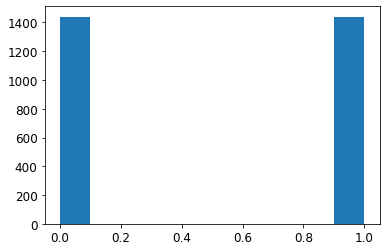

In [73]:
plt.hist(y_train)
# plt.hist(y_val)
# plt.xticks(['out','in', 'normal', 'other', 'noise'])

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100) # 주성분을 몇개로 할지 결정
X_train = pca.fit_transform(X_train)
X_train.shape

(26880, 100)

In [22]:
from datetime import datetime
c= datetime.now()
a = c.strftime('%Y-%m-%d_%H_%M')
print(a)

import time

def hms(s):
    hours = s // 3600
    s = s - hours*3600
    mu = s // 60
    ss = s - mu*60
    return hours, mu, ss


##dense layer 바꿈
from tensorflow import keras
from datetime import datetime
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

#####
def train_model(model,X_train,X_test, batch_size = 128, optimizer='adam',patience=10, matrix = True,
                class_weight=True, epoch = 100,reshape = False, make_csv = False,):

    c = datetime.now() ##모델 돌릴 때 시작 시간
    n_time = c.strftime('%Y-%m-%d_%H_%M')
    print(n_time)

    
    if reshape ==True: ##데이터 reshape -> cnn 돌릴때
        X_tr=X_train.reshape((-1,X_train.shape[1],X_train.shape[2],1))
        X_te=X_test.reshape((-1,X_test.shape[1],X_test.shape[2],1))
    else:
        X_tr = X_train
        X_te = X_test
    print(X_tr.shape)
    
    
    MODEL_SAVE_FOLDER_PATH = './model/'  #모델 저장 경로
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    model_path = MODEL_SAVE_FOLDER_PATH + str(n_time)+'.hdf5'


    es = EarlyStopping(monitor='val_loss', mode='min', 
                       verbose=1, patience=patience, restore_best_weights = True)

    mc = ModelCheckpoint(model_path, monitor='val_loss',
                         mode='min', save_best_only=True)

    if class_weight==True:
        class_weights = compute_class_weight(class_weight = 'balanced',
                                                         classes = np.unique(y_train),
                                                         y = y_train)
        class_weights = dict(enumerate(class_weights))
    else:
        class_weights = None


    model.compile(loss='sparse_categorical_crossentropy',
                          optimizer = optimizer
                         ,metrics=['accuracy'])


    start = time.time()

    #model fit
    history = model.fit(X_tr,y_train, epochs = epoch,
                     batch_size=batch_size, validation_split=0.2, 
                                callbacks=[es, mc],
                               class_weight = class_weights,
                                shuffle=True,
                       ).history

    terminate_time = time.time() - start
    
    # training time
    hours, mu, ss = hms(terminate_time)
    print('training time: ', hours, 'h', mu, 'm', ss, 's')    
    print('\n-----test score : ',model.evaluate(X_te, y_test))
    
    #러닝 커브
    plt.plot(history['accuracy'], label='train_acc')
    plt.plot(history['val_accuracy'], label= 'val_acc')
    plt.plot(history['loss'], label= 'train_loss')
    plt.plot(history['val_loss'], label= 'val_loss')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.legend(loc='lower left')
    plt.show()
    
    
    print_acc(model, matrix=True ,X_te=X_test, reshape = reshape)
    if(make_csv == True):
        submit_pd = make_test_csv(model,model_name = n_time, reshape=reshape)
        return submit_pd

    
    
# inference     
import seaborn as sns
from sklearn.metrics import confusion_matrix


def print_acc(model, matrix =True, X_te=X_test , reshape = False):
    
    if reshape ==True: ##데이터 reshape -> cnn 돌릴때
        X_te=X_test.reshape((-1,X_te.shape[1],X_te.shape[2],1))
    else:
        X_te = X_te
        
    print(X_te.shape)
    
    y_pred = np.argmax(model.predict(X_te),axis =1)
    cf = confusion_matrix(y_test, y_pred)

    per_cf =[]
    for i in cf:
        per_cf.append(i/np.sum(i))
    axes=[]
#     plt.rc('font', size=10)
    for i , cf in enumerate([cf, per_cf]):
        fig=plt.figure(figsize=(8,8))
        axes.append(fig.add_subplot(2,2,i+1))
        ax = sns.heatmap(np.round(cf,4),annot=True, fmt='', cmap='Blues')#확률로 표시
        ax.set_title('Seaborn Confusion Matrix with labels\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');
        fig.tight_layout()
        ## Display the visualiztion of the Confusion Matrix.
        plt.show()
        
        
def make_test_csv(model,model_name,reshape=False):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
    pred = np.argmax(model.predict(submit_te),axis = 1)
    print(pred.shape)
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)
    print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
    plt.hist(np.array(submit_pd))
    plt.show()
    
    MODEL_SAVE_FOLDER_PATH = './result_csv/' 
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[:-5]+'.csv')
    print(model_name)
    return submit_pd
    

    
def load_model_list(dir_name):
    for dirname,_, filenames in os.walk(dir_name):
        model_list= filenames
        print(filenames) 
        
        
def show_matrix(y_test,y_pred):
    cf = confusion_matrix(y_test, y_pred)

    per_cf =[]
    for i in cf:
        per_cf.append(i/np.sum(i))
    axes=[]
#     plt.rc('font', size=10)
    for i , cf in enumerate([cf, per_cf]):
        fig=plt.figure(figsize=(8,8))
        axes.append(fig.add_subplot(2,2,i+1))
        ax = sns.heatmap(np.round(cf,4),annot=True, fmt='', cmap='Blues')#확률로 표시
        ax.set_title('Seaborn Confusion Matrix with labels\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');
        fig.tight_layout()
        ## Display the visualiztion of the Confusion Matrix.
        plt.show()

2022-06-16_19_10


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_35 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_36 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_37 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 13, 9, 129)       

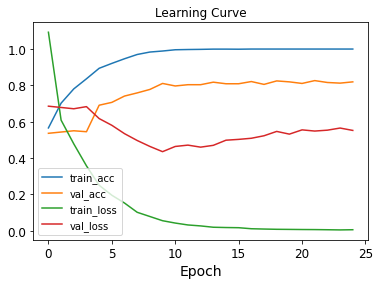

(720, 27, 19, 1)


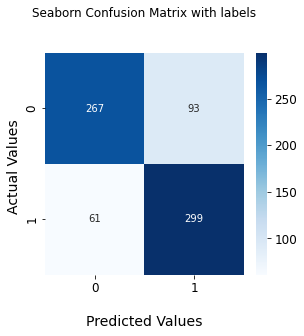

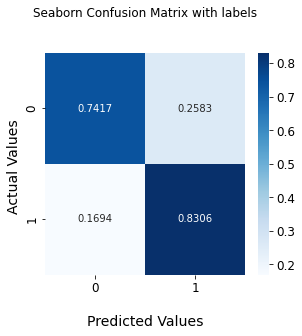

In [76]:
################## ifft -> stft  shape = (none,43,19,1)
batch_size= 64
X_train, X_test , submit_test =data_reshape([X_train,X_test,submit_test],(-1,27,19,1))

input_shape = (X_train.shape[1],X_train.shape[2],1)

model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    keras.layers.Conv2D(129, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Conv2D(256, kernel_size=3, strides=1, activation='relu', padding='valid'), #C5
    layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
#     keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(2, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 16)           96        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 16)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 12, 64)            5184      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2, 128)            41088     
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0   

Epoch 48/100
36/36 [==============================] - 0s 7ms/step - loss: 0.5724 - accuracy: 0.6955 - val_loss: 0.6584 - val_accuracy: 0.6111
Epoch 49/100
36/36 [==============================] - 0s 7ms/step - loss: 0.5684 - accuracy: 0.6927 - val_loss: 0.6282 - val_accuracy: 0.6302
Epoch 50/100
36/36 [==============================] - 0s 9ms/step - loss: 0.5671 - accuracy: 0.7036 - val_loss: 0.6815 - val_accuracy: 0.5920
Epoch 51/100
36/36 [==============================] - 0s 9ms/step - loss: 0.5504 - accuracy: 0.7041 - val_loss: 0.6258 - val_accuracy: 0.6389
Epoch 52/100
36/36 [==============================] - 0s 9ms/step - loss: 0.5574 - accuracy: 0.6981 - val_loss: 0.6265 - val_accuracy: 0.6545
Epoch 53/100
36/36 [==============================] - 0s 8ms/step - loss: 0.5721 - accuracy: 0.6960 - val_loss: 0.6290 - val_accuracy: 0.6458
Epoch 54/100
36/36 [==============================] - 0s 8ms/step - loss: 0.5674 - accuracy: 0.6861 - val_loss: 0.6205 - val_accuracy: 0.6528
Epoch 

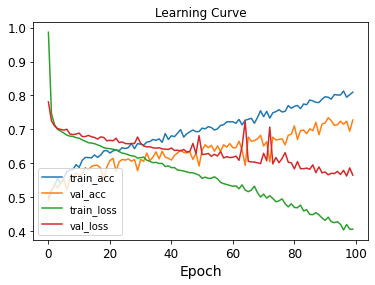

(720, 100)


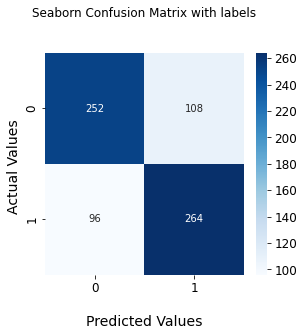

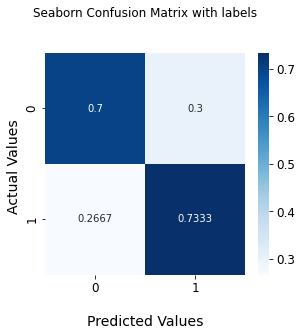

In [51]:
#LeNet-5 구조
batch_size = 64

#LeNet-5 구조 -> maxpool 추가
batch_size = 64

input_layer = keras.Input(shape = (X_train.shape[1],1))
x=keras.layers.Conv1D(16, kernel_size=5,strides=1,  activation='relu', padding='same')(input_layer) #C11
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(64, kernel_size=5, strides=4, activation='relu', padding='valid')(x)
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(128, kernel_size=5, strides=1, activation='tanh', padding='valid')(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(84, activation='tanh')(x)
out = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer,out)
model.summary()


train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd', class_weight=True)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 8, 8, 1)           4         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 16)          416       
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 8, 16)          64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 64)          25664     
_________________________________________________________________
batch_normalization_18 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 64)         

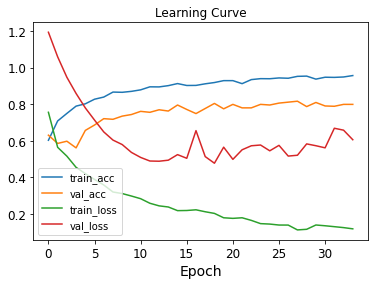

(720, 8, 8, 1)


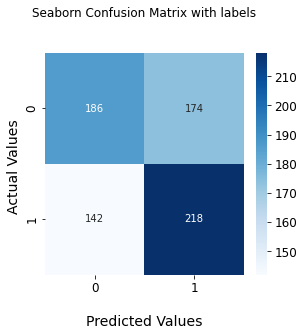

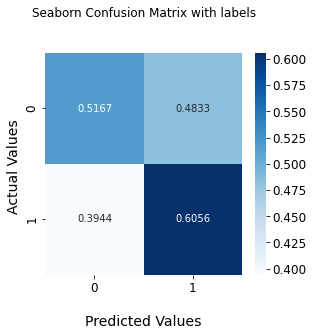

In [66]:
################## ifft -> stft  shape = (none,43,19,1)
batch_size= 64

X_train, X_test , submit_test =data_reshape([X_train,X_test,submit_test],(-1,8,8,1))

input_shape = (X_train.shape[1],X_train.shape[2],1)

model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(4, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train,X_test,batch_size,patience = 15,optimizer = 'sgd',reshape=True, class_weight=True)

